# Train DDC Model for Conditional Generation

In [1]:
# change working path to the current file
%cd ..

/home/hudongcheng/Desktop/bo_osda_generator


In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.backends.cudnn as cudnn

# import custom modules
from models.ddc import SMILESGenerator
from utils.utils import *
from datasets.data_loader import *
from utils.plot_figures import *
from utils.metrics import *
from utils.build_vocab import *

In [3]:
cudnn.benchmark = True
cudnn.enabled = True

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

log_dir = './logs/'
save_best_weight_path = './checkpoints/'

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

In [4]:
PAD = 0
UNK = 1
EOS = 2
SOS = 3
MASK = 4
MAX_LEN = 220

In [5]:
# read the data and convert to the format we need
train_smiles = read_strings('./data/train_smiles.csv', idx=False)
train_zeo = read_vec('./data/train_zeo.csv', idx=False)
train_syn = read_vec('./data/train_syn.csv', idx=False)
train_codes = read_strings('./data/train_codes.csv', idx=False)
test_smiles = read_strings('./data/test_smiles.csv', idx=False)
test_zeo = read_vec('./data/test_zeo.csv', idx=False)
test_syn = read_vec('./data/test_syn.csv', idx=False)
test_codes = read_strings('./data/test_codes.csv', idx=False)

vocab = WordVocab.load_vocab('./model_hub/vocab.pkl')
print('the vocab size is :', len(vocab))

charlen = len(vocab)
print('the total num of charset is :', charlen)

the vocab size is : 45
the total num of charset is : 45


In [6]:
# hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 512
epoch = 20

In [7]:
# create the dataset and dataloader
train_dataset = Seq2seqDataset(train_zeo, train_syn, train_smiles, vocab)
test_dataset = Seq2seqDataset(test_zeo, test_syn, test_smiles, vocab)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# create the model
model = SMILESGenerator(condition_dim=24, lstm_dim=256, dec_layers=3, charset_size=charlen).to(device)
# loss
loss_func = torch.nn.CrossEntropyLoss(ignore_index=PAD)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
total = sum(p.numel() for p in model.parameters())
print('total parameters: %0.2fM' % (total / 1e6))

total parameters: 1.41M


In [8]:
# train function
def train(model, dataloader, loss_func, optim, device):
    model.train()
    total_loss = 0
    total_acc = 0
    total_num = 0
    for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
        zeo = zeo.to(device)
        syn = syn.to(device)
        tgt = tgt.to(device)
        # teacher forcing
        condition = torch.cat([zeo, syn], dim=-1)
        tgt_input = tgt[:, :-1].contiguous()
        tgt_output = tgt[:, 1:].contiguous()
        # convert the tgt_input to one-hot
        tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
        
        optim.zero_grad()
        output = model(condition, tgt_input)
        
        # reshape the output to calculate the loss
        output = output.view(-1, output.size(-1))
        tgt_output = tgt_output.view(-1)
        loss = loss_func(output, tgt_output)
        
        # backward and update
        loss.backward()
        optim.step()
        
        # calculate the accuracy and loss
        total_loss += loss.item()
        pred = output.argmax(dim=-1)
        num_correct = (pred == tgt_output) & (tgt_output != PAD)
        num_words = (tgt_output != PAD).sum().item()
        total_acc += num_correct.sum().item()
        total_num += num_words
    return total_loss / len(dataloader), total_acc / total_num

In [9]:
# test function
def test(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for i, (zeo, syn, tgt) in enumerate(tqdm(dataloader)):
            zeo = zeo.to(device)
            syn = syn.to(device)
            tgt = tgt.to(device)
            condition = torch.cat([zeo, syn], dim=-1)
            tgt_input = tgt[:, :-1].contiguous()
            tgt_output = tgt[:, 1:].contiguous()
            tgt_input = F.one_hot(tgt_input, num_classes=charlen).float()
            output = model(condition, tgt_input)
            output = output.view(-1, output.size(-1))
            tgt_output = tgt_output.view(-1)
            loss = loss_func(output, tgt_output)
            total_loss += loss.item()
            pred = output.argmax(dim=-1)
            num_correct = (pred == tgt_output) & (tgt_output != PAD)
            num_words = (tgt_output != PAD).sum().item()
            total_acc += num_correct.sum().item()
            total_num += num_words
    return total_loss / len(dataloader), total_acc / total_num

In [10]:
# train the model
for i in range(epoch):
    train_loss, train_acc = train(model, train_dataloader, loss_func, optim, device)
    test_loss, test_acc = test(model, test_dataloader, loss_func, device)
    print('epoch %d, train loss %.4f, train acc %.4f, test loss %.4f, test acc %.4f' % (i, train_loss, train_acc, test_loss, test_acc))
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    if i == 0:
        best_acc = test_acc
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'best_ddc_model.pth'))
    torch.save(model.state_dict(), os.path.join(save_best_weight_path, 'last_ddc_model.pth'))

100%|██████████| 68/68 [00:04<00:00, 15.11it/s]


epoch 0, train loss 2.1110, train acc 0.3872, test loss 1.8935, test acc 0.4210


100%|██████████| 68/68 [00:04<00:00, 15.20it/s]


epoch 1, train loss 1.4738, train acc 0.5319, test loss 1.2894, test acc 0.5862


100%|██████████| 68/68 [00:04<00:00, 15.04it/s]


epoch 2, train loss 1.1410, train acc 0.6252, test loss 1.0780, test acc 0.6389


100%|██████████| 68/68 [00:04<00:00, 15.18it/s]


epoch 3, train loss 0.9397, train acc 0.6837, test loss 0.8888, test acc 0.7019


100%|██████████| 68/68 [00:04<00:00, 15.08it/s]


epoch 4, train loss 0.8055, train acc 0.7243, test loss 0.8022, test acc 0.7245


100%|██████████| 68/68 [00:04<00:00, 15.04it/s]


epoch 5, train loss 0.7154, train acc 0.7513, test loss 0.7275, test acc 0.7467


100%|██████████| 68/68 [00:04<00:00, 15.18it/s]


epoch 6, train loss 0.6478, train acc 0.7718, test loss 0.6617, test acc 0.7680


100%|██████████| 68/68 [00:04<00:00, 15.03it/s]


epoch 7, train loss 0.5984, train acc 0.7867, test loss 0.6019, test acc 0.7877


100%|██████████| 68/68 [00:04<00:00, 15.24it/s]


epoch 8, train loss 0.5600, train acc 0.7980, test loss 0.5726, test acc 0.7965


100%|██████████| 68/68 [00:04<00:00, 15.08it/s]


epoch 9, train loss 0.5301, train acc 0.8065, test loss 0.5421, test acc 0.8051


100%|██████████| 68/68 [00:04<00:00, 15.07it/s]


epoch 10, train loss 0.5061, train acc 0.8132, test loss 0.5254, test acc 0.8083


100%|██████████| 68/68 [00:04<00:00, 15.18it/s]


epoch 11, train loss 0.4852, train acc 0.8190, test loss 0.4942, test acc 0.8180


100%|██████████| 68/68 [00:04<00:00, 15.15it/s]


epoch 12, train loss 0.4670, train acc 0.8241, test loss 0.4815, test acc 0.8217


100%|██████████| 68/68 [00:04<00:00, 15.02it/s]


epoch 13, train loss 0.4519, train acc 0.8282, test loss 0.4724, test acc 0.8228


100%|██████████| 68/68 [00:04<00:00, 15.10it/s]


epoch 14, train loss 0.4412, train acc 0.8309, test loss 0.4545, test acc 0.8277


100%|██████████| 68/68 [00:04<00:00, 15.15it/s]


epoch 15, train loss 0.4286, train acc 0.8342, test loss 0.4427, test acc 0.8309


100%|██████████| 68/68 [00:04<00:00, 15.11it/s]


epoch 16, train loss 0.4192, train acc 0.8368, test loss 0.4314, test acc 0.8352


100%|██████████| 68/68 [00:04<00:00, 15.05it/s]


epoch 17, train loss 0.4119, train acc 0.8386, test loss 0.4256, test acc 0.8361


100%|██████████| 68/68 [00:04<00:00, 15.18it/s]


epoch 18, train loss 0.4032, train acc 0.8409, test loss 0.4169, test acc 0.8387


100%|██████████| 68/68 [00:04<00:00, 15.07it/s]

epoch 19, train loss 0.3970, train acc 0.8426, test loss 0.4116, test acc 0.8394


In [11]:
def generate_ddc(model, start_sequence, condition, max_length, vocab,  device, temperature=0.5, top_k=0):
    """
    Autoregressive generation process for a GPT model.

    Args:
        model (ddc): The pre-trained GPT model for token generation.
        start_sequence (torch.Tensor): The initial sequence to start generation (batch_size, seq_length).
        condition_props (torch.Tensor): The conditional property vector (batch_size, num_props).
        max_length (int): The maximum length of the generated sequence.
        vocab: The vocabulary object for encoding and decoding SMILES strings.
        device (torch.device): The device on which to run the generation.
        temperature (float): Temperature parameter for sampling; higher values increase randomness.
        top_k (int): Limits sampling to top-k logits; if 0, no top-k sampling is applied.

    Returns:
        List[str]: A list of generated SMILES strings.
    """

    model.eval()
    batch_size = start_sequence.size(0)
    generated_seq = start_sequence.clone().to(device)
    
    with torch.no_grad():
        # We will iteratively fill positions from [start_len ... seqlen-1]
        for cur_len in range(max_length - start_sequence.size(1)):
            current_len = generated_seq.size(1)
            generated_seq_hot = F.one_hot(generated_seq, num_classes=len(vocab)).float()
            # forward pass to get logits
            logits = model(condition, generated_seq_hot)
            # extract the logits for the next token
            next_token_logits = logits[:, -1, :]
            # temperature scaling
            next_token_logits /= temperature
            # top-k sampling
            if top_k > 0:
                next_token_logits, top_k_indices = torch.topk(next_token_logits, top_k, dim=-1)
                next_token_probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(next_token_probs, num_samples=1)
            else:
                # sample from the distribution
                next_token = torch.multinomial(F.softmax(next_token_logits, dim=-1), num_samples=1)
            # append the new token to the sequence
            generated_seq = torch.cat([generated_seq, next_token], dim=-1)
            
            # check if all sequences have reached EOS
            if all(next_token[i].item() == EOS for i in range(batch_size)):
                break
    
    # Decode the generated sequences into SMILES strings
    generated_smiles = []
    for seq in generated_seq:
        # Convert indices to characters, ignoring padding and start tokens
        # check if the generated sequence contains the end token, if meet, stop decoding
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        generated_smiles.append(smiles)

    return generated_smiles


In [18]:
# generate the smiles for the test dataset
generated_smile = []
target_smile = []
for i, (zeo, syn, tgt) in enumerate(tqdm(test_dataloader)):
    zeo = zeo.to(device)
    syn = syn.to(device)
    tgt = tgt.to(device)
    condition_synthesis = torch.cat([zeo, syn], dim=1)
    generated_smiles = generate_ddc(model, tgt[:, :10], condition_synthesis, MAX_LEN, vocab, device, 0.5)
    generated_smile.extend(generated_smiles)
    # convert the tgt to smiles
    tgt_smiles = []
    for seq in tgt:
        smiles = ''
        for idx in seq:
            if idx.item() == EOS:
                break
            elif idx.item() != PAD and idx.item() != SOS:
                smiles += vocab.itos[idx.item()]
        tgt_smiles.append(smiles)
    target_smile.extend(tgt_smiles)

100%|██████████| 68/68 [02:44<00:00,  2.42s/it]


In [19]:
# calculate the metrics
print('Validity rate:', validity_rate(generated_smiles))
print('Uniqueness rate:', uniqueness_rate(generated_smiles))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('Reconstructability rate:', reconstructability_rate(generated_smiles, target_smile))
print('Novelty rate:', novelty_rate(generated_smiles, target_smile))
print('IntDiv:', IntDiv(generated_smiles))
# print('KL-divergence:', KL_divergence(target_smile), generated_smile))
print('FCD score:', FCD_score(target_smile, generated_smile))

[17:40:20] SMILES Parse Error: unclosed ring for input: 'C1CC[N+]2(CC1CCCCCC2)CC1'
[17:40:20] SMILES Parse Error: syntax error while parsing: C1CCC2C([C+]33Cn(C4)C3CCC4)(12CCCC
[17:40:20] SMILES Parse Error: Failed parsing SMILES 'C1CCC2C([C+]33Cn(C4)C3CCC4)(12CCCC' for input: 'C1CCC2C([C+]33Cn(C4)C3CCC4)(12CCCC'
[17:40:20] SMILES Parse Error: extra close parentheses while parsing: C1[N+]2(CCCCCC))C(CC2CCCCC2)C1
[17:40:20] SMILES Parse Error: Failed parsing SMILES 'C1[N+]2(CCCCCC))C(CC2CCCCC2)C1' for input: 'C1[N+]2(CCCCCC))C(CC2CCCCC2)C1'
[17:40:20] SMILES Parse Error: syntax error while parsing: C1CCCC2CC[[+]]3[c+)(cccc1)C2
[17:40:20] SMILES Parse Error: Failed parsing SMILES 'C1CCCC2CC[[+]]3[c+)(cccc1)C2' for input: 'C1CCCC2CC[[+]]3[c+)(cccc1)C2'
[17:40:20] SMILES Parse Error: unclosed ring for input: 'C12CCCCC1CCC[N+]21CcCcccc1C2'
[17:40:20] SMILES Parse Error: unclosed ring for input: 'C12C(CCC[N+]13CCCC33)CCCC[N+]1(C)C2'
[17:40:20] SMILES Parse Error: unclosed ring for input: 'C1

Validity rate: 0.42
Uniqueness rate: 0.87
Novelty rate: 0.7540229885057471
Reconstructability rate: 0.24597701149425288
Novelty rate: 0.7540229885057471
IntDiv: 0.8093305125891832


[17:40:23] non-ring atom 15 marked aromatic
[17:40:23] SMILES Parse Error: extra close parentheses while parsing: c1cn(C)c(C)[n+]1Cc1cccCC[n+]2ccC(C)c2C)c1
[17:40:23] SMILES Parse Error: Failed parsing SMILES 'c1cn(C)c(C)[n+]1Cc1cccCC[n+]2ccC(C)c2C)c1' for input: 'c1cn(C)c(C)[n+]1Cc1cccCC[n+]2ccC(C)c2C)c1'
[17:40:23] SMILES Parse Error: extra close parentheses while parsing: c1[n+](Cc2ccccCC[n+]3c(C)n(C)cc3)c2)c(C)n(C)c1
[17:40:23] SMILES Parse Error: Failed parsing SMILES 'c1[n+](Cc2ccccCC[n+]3c(C)n(C)cc3)c2)c(C)n(C)c1' for input: 'c1[n+](Cc2ccccCC[n+]3c(C)n(C)cc3)c2)c(C)n(C)c1'
[17:40:23] SMILES Parse Error: extra close parentheses while parsing: Cc1n(C)cc[n+]1Cc1cccCC[n+]2c(n)c(C)c2C)c1
[17:40:23] SMILES Parse Error: Failed parsing SMILES 'Cc1n(C)cc[n+]1Cc1cccCC[n+]2c(n)c(C)c2C)c1' for input: 'Cc1n(C)cc[n+]1Cc1cccCC[n+]2c(n)c(C)c2C)c1'
[17:40:23] SMILES Parse Error: syntax error while parsing: C(c1ccccc1C[N+]2(C)3CC((C)CC))CCN)1C
[17:40:23] SMILES Parse Error: Failed parsing SMILES 

FCD score: 0.44258106874334047


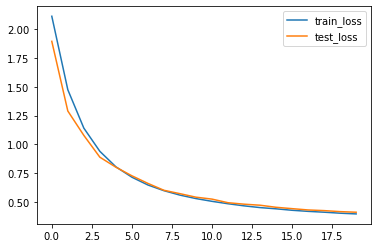

In [20]:
# plot the loss and acc
plot_loss(train_loss_history, test_loss_history, 'ddc')